In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from keras.layers import Reshape, MaxPooling2D, Lambda, SeparableConv2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.layers.merge import concatenate
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# Connecting Drive to save models
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


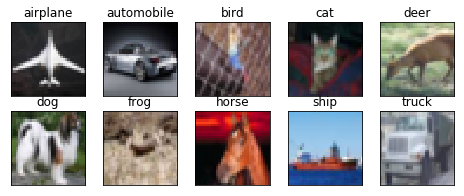

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size = 2)

In [0]:
# Define the model

input = Input(shape = (img_rows, img_cols, img_channels))


# Initial Conv - Layer 1
layer1 = SeparableConv2D(16, (5, 5), strides = (1, 1), padding = 'same', name = 'Initial_S5')(input) #32

skip1 = layer1


# Layer 2
layer2 = BatchNormalization(name = 'layer2_BN')(layer1)
layer2 = Activation('relu', name = 'layer2_Relu')(layer2)
layer2 = Conv2D(40, (5, 5), strides = (1, 1), padding = 'same', name = 'layer2_5')(layer2) #32

skip2 = layer2


# Layer 3
layer3 = BatchNormalization(name = 'layer3_BN')(layer2)
layer3 = Activation('relu', name = 'layer3_Relu')(layer3)
layer3 = Conv2D(64, (5, 5), strides = (1, 1), padding = 'same', name = 'layer3_5')(layer3) #32

skip3 = layer3


# Layer 4
conlayer4 = concatenate([skip1, layer3], name = 'concat_layer4')

redlayer4 = BatchNormalization(name = 'redlayer4_BN')(conlayer4)
redlayer4 = Activation('relu', name = 'redlayer4_Relu')(redlayer4)
redlayer4 = Conv2D(64, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer4_1')(redlayer4)

layer4 = BatchNormalization(name = 'layer4_BN')(redlayer4)
layer4 = Activation('relu', name = 'layer4_Relu')(layer4)
layer4 = SeparableConv2D(88, (5, 5), strides = (1, 1), padding = 'same', name = 'layer4_S5')(layer4) #32

skip4 = layer4


# Layer 5
conlayer5 = concatenate([skip1, layer4], name = 'concat_layer5')

layer5 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_5')(conlayer5)

layer5 = BatchNormalization(name = 'layer5_BN')(layer5)
layer5 = Activation('relu', name = 'layer5_Relu')(layer5)
layer5 = Conv2D(44, (1, 1), strides = (1, 1), padding = 'same', name = 'layer5_1')(layer5) #16
layer5 = Dropout(0.1, name = 'layer5_DO')(layer5)



# Space to Depth connections of Block1
skip1_sd1 = Lambda(space_to_depth_x2, name = 'skip1_sd1')(skip1)
skip2_sd1 = Lambda(space_to_depth_x2, name = 'skip2_sd1')(skip2)
skip3_sd1 = Lambda(space_to_depth_x2, name = 'skip3_sd1')(skip3)
skip4_sd1 = Lambda(space_to_depth_x2, name = 'skip4_sd1')(skip4)

# Layer 6
layer6 = BatchNormalization(name = 'layer6_BN')(layer5)
layer6 = Activation('relu', name = 'layer6_Relu')(layer6)
layer6 = SeparableConv2D(68, (3, 3), strides = (1, 1), padding = 'same', name = 'layer6_S3')(layer6) #16

skip6 = layer6


# Layer 7
conlayer7 = concatenate([skip1_sd1, skip4_sd1, layer6], name = 'concat_layer7')

redlayer7 = BatchNormalization(name = 'redlayer7_BN')(conlayer7)
redlayer7 = Activation('relu', name = 'redlayer7_Relu')(redlayer7)
redlayer7 = Conv2D(68, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer7_1')(redlayer7)

layer7 = BatchNormalization(name = 'layer7_BN')(redlayer7)
layer7 = Activation('relu', name = 'layer7_Relu')(layer7)
layer7 = Conv2D(92, (5, 5), strides = (1, 1), padding = 'same', name = 'layer7_5')(layer7) #16

skip7 = layer7


# Layer 8
conlayer8 = concatenate([skip3_sd1, skip4_sd1, skip6,  layer7], name = 'concat_layer8')

redlayer8 = BatchNormalization(name = 'redlayer8_BN')(conlayer8)
redlayer8 = Activation('relu', name = 'redlayer8_Relu')(redlayer8)
redlayer8 = Conv2D(92, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer8_1')(redlayer8)

layer8 = BatchNormalization(name = 'layer8_BN')(redlayer8)
layer8 = Activation('relu', name = 'layer8_Relu')(layer8)
layer8 = SeparableConv2D(116, (3, 3), strides = (1, 1), padding = 'same', name = 'layer8_S3')(layer8) #16

skip8 = layer8


# Layer 9
conlayer9 = concatenate([skip1_sd1, skip3_sd1, skip4_sd1, skip6, skip7, layer8], name = 'concat_layer9')

redlayer9 = BatchNormalization(name = 'redlayer9_BN')(conlayer9)
redlayer9 = Activation('relu', name = 'redlayer9_Relu')(redlayer9)
redlayer9 = Conv2D(116, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer9_1')(redlayer9)

layer9 = BatchNormalization(name = 'layer9_BN')(redlayer9)
layer9 = Activation('relu', name = 'layer9_Relu')(layer9)
layer9 = SeparableConv2D(140, (5, 5), strides = (1, 1), padding = 'same', name = 'layer9_S5')(layer9) #16


# Layer 10
conlayer10 = concatenate([skip1_sd1, skip4_sd1, skip6, skip8, layer9], name = 'concat_layer10')

layer10 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPool_10')(conlayer10)

layer10 = BatchNormalization(name = 'layer10_BN')(layer10)
layer10 = Activation('relu', name = 'layer10_Relu')(layer10)
layer10 = Conv2D(70, (1, 1), strides = (1, 1), padding = 'same', name = 'layer10_1')(layer10) #8
layer10 = Dropout(0.1, name = 'layer10_DO')(layer10)

# Space to Depth connections of Block 1 and 2
skip1_sd2 = Lambda(space_to_depth_x2, name = 'skip1_sd2')(skip1_sd1)
skip2_sd2 = Lambda(space_to_depth_x2, name = 'skip2_sd2')(skip2_sd1)
skip3_sd2 = Lambda(space_to_depth_x2, name = 'skip3_sd2')(skip3_sd1)
skip4_sd2 = Lambda(space_to_depth_x2, name = 'skip4_sd2')(skip4_sd1)
skip6_sd2 = Lambda(space_to_depth_x2, name = 'skip6_sd2')(skip6)
skip7_sd2 = Lambda(space_to_depth_x2, name = 'skip7_sd2')(skip7)
skip8_sd2 = Lambda(space_to_depth_x2, name = 'skip8_sd2')(skip8)

# Layer 11
conlayer11 = concatenate([skip7_sd2, layer10], name = 'concat_layer11')

redlayer11 = BatchNormalization(name = 'redlayer11_BN')(conlayer11)
redlayer11 = Activation('relu', name = 'redlayer11_Relu')(redlayer11)
redlayer11 = Conv2D(70, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer11_1')(redlayer11)

layer11 = BatchNormalization(name = 'layer11_BN')(redlayer11)
layer11 = Activation('relu', name = 'layer11_Relu')(layer11)
layer11 = Conv2D(94, (5, 5), strides = (1, 1), padding = 'same', name = 'layer11_5')(layer11) #8

skip11 = layer11


# Layer 12
conlayer12 = concatenate([skip2_sd2, skip4_sd2, skip8_sd2, layer11], name = 'concat_layer12')

redlayer12 = BatchNormalization(name = 'redlayer12_BN')(conlayer12)
redlayer12 = Activation('relu', name = 'redlayer12_Relu')(redlayer12)
redlayer12 = Conv2D(94, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer12_1')(redlayer12)

layer12 = BatchNormalization(name = 'layer12_BN')(redlayer12)
layer12 = Activation('relu', name = 'layer12_Relu')(layer12)
layer12 = SeparableConv2D(118, (5, 5), strides = (1, 1), padding = 'same', name = 'layer12_S5')(layer12) #8

skip12 = layer12


# Layer 13
conlayer13 = concatenate([skip2_sd2, skip3_sd2, skip6_sd2, skip11, layer12], name = 'concat_layer13')

redlayer13 = BatchNormalization(name = 'redlayer13_BN')(conlayer13)
redlayer13 = Activation('relu', name = 'redlayer13_Relu')(redlayer13)
redlayer13 = Conv2D(118, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer13_1')(redlayer13)

layer13 = BatchNormalization(name = 'layer13_BN')(redlayer13)
layer13 = Activation('relu', name = 'layer13_Relu')(layer13)
layer13 = Conv2D(142, (3, 3), strides = (1, 1), padding = 'same', name = 'layer13_3')(layer13) #8


# Layer 14
conlayer14 = concatenate([skip1_sd2, skip3_sd2,  skip4_sd2, skip6_sd2, skip8_sd2, skip12, layer13], name = 'concat_layer14')

redlayer14 = BatchNormalization(name = 'redlayer14_BN')(conlayer14)
redlayer14 = Activation('relu', name = 'redlayer14_Relu')(redlayer14)
redlayer14 = Conv2D(142, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer14_1')(redlayer14)

layer14 = BatchNormalization(name = 'layer14_BN')(redlayer14)
layer14 = Activation('relu', name = 'layer14_Relu')(layer14)
layer14 = SeparableConv2D(166, (5, 5), strides = (1, 1), padding = 'same', name = 'layer14_S5')(layer14) #8


# Layer 15
conlayer15 = concatenate([skip4_sd2, skip8_sd2, skip12, layer14], name = 'concat_layer15')

redlayer15 = BatchNormalization(name = 'redlayer15_BN')(conlayer15)
redlayer15 = Activation('relu', name = 'redlayer15_Relu')(redlayer15)
redlayer15 = Conv2D(10, (1, 1), strides = (1, 1), padding = 'same', name = 'redlayer15_1')(redlayer15) #8

layer15 = GlobalAveragePooling2D()(redlayer15)  #1
output = Activation("softmax")(layer15)

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Initial_S5 (SeparableConv2D)    (None, 32, 32, 16)   139         input_2[0][0]                    
__________________________________________________________________________________________________
layer2_BN (BatchNormalization)  (None, 32, 32, 16)   64          Initial_S5[0][0]                 
__________________________________________________________________________________________________
layer2_Relu (Activation)        (None, 32, 32, 16)   0           layer2_BN[0][0]                  
__________________________________________________________________________________________________
layer2_5 (

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
filepath="/content/gdrive/My Drive/EVA/P7-24 - BestExp.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=200, epochs=100)`


Epoch 1/100
200/200 [==============================] - 88s 441ms/step - loss: 1.3642 - acc: 0.5030 - val_loss: 1.5288 - val_acc: 0.4626

Epoch 00001: val_acc improved from -inf to 0.46260, saving model to /content/gdrive/My Drive/EVA/P7-24 - BestExp.hdf5
Epoch 2/100
200/200 [==============================] - 83s 415ms/step - loss: 0.8946 - acc: 0.6815 - val_loss: 1.4158 - val_acc: 0.5238

Epoch 00002: val_acc improved from 0.46260 to 0.52380, saving model to /content/gdrive/My Drive/EVA/P7-24 - BestExp.hdf5
Epoch 3/100
200/200 [==============================] - 83s 414ms/step - loss: 0.6796 - acc: 0.7622 - val_loss: 1.4532 - val_acc: 0.5980

Epoch 00003: val_acc improved from 0.52380 to 0.59800, saving model to /content/gdrive/My Drive/EVA/P7-24 - BestExp.hdf5
Epoch 4/100
200/200 [==============================] - 83s 414ms/step - loss: 0.5512 - acc: 0.8064 - val_loss: 1.0225 - val_acc: 0.6794

Epoch 00004: val_acc improved from 0.59800 to 0.67940, saving model to /content/gdrive/My Dr

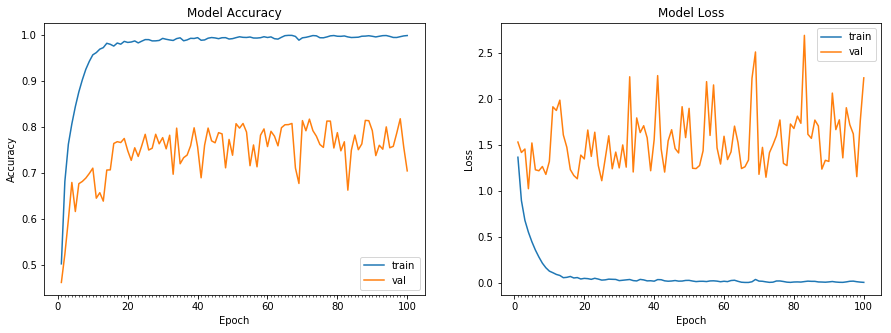

Accuracy on test data is: 70.45


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, 
                                              train_labels, 
                                              batch_size = 250),
                                 samples_per_epoch = train_features.shape[0],
                                 nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),
                                 verbose = 1,
                                callbacks = [checkpoint])

# model_info = model.fit(train_features, train_labels,
#           batch_size = 500,
#           epochs = 100,
#           validation_data = (test_features, test_labels))



end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))